In [1]:
CHAR_DEF = [
    'BLANK', '>', ',', '?', '.',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 
    'H', 'I', 'J', 'K', 'L', 'M', 'N', 
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
    'V', 'W', 'X', 'Y', 'Z']
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import re
import time
import pickle
import redis
import argparse
import json
from pathlib import Path

session = 't18.2025.01.15'
dataDir = str(Path('../Data', 't18', session, 'Typing'))
blocks = [14]
all_block_mats = []
for b in blocks:
    filename = [str(x) for x in Path(dataDir, 'RedisMat').glob('*('+str(b)+').mat')][0]
    mat = scipy.io.loadmat(filename)
    all_block_mats.append(mat)

import tensorflow as tf

all_trial_times = []
trial_decodes = []
current_logits = []
all_trial_logits = []
logit_index = 0
redis_clock = []
current_redis_clock = []
cue = []
for b in all_block_mats:
    logit_index = 0
    for trial, (start_time, end_time) in enumerate(zip(b['go_cue_redis_time'][0], b['trial_end_redis_time'][0])):
        all_trial_times.append((end_time-start_time)/(1000*60))
        current_trial = []
        current_logits = []
        current_redis_clock = []
        cue.append(b['cue'][trial].strip())
        while b['decoder_output_redis_clock'][0][logit_index] < end_time:
            if b['decoder_output_redis_clock'][0][logit_index] < start_time:
                logit_index += 1
                continue
            l = b['decoder_logit_output'][logit_index, :31]
            current_logits.append(l)
            current_redis_clock.append(b['decoder_output_redis_clock'][0][logit_index] - start_time)
            logit_index += 1
        all_trial_logits.append(np.array(current_logits))
        redis_clock.append(current_redis_clock)
        current_logits = np.expand_dims(np.array(current_logits), axis=1)
        seq_len = np.expand_dims(current_logits.shape[0], axis=0)
        nTimeSteps = tf.cast((seq_len - 14) / 4 + 1, dtype=tf.int32)
        decoded_sequence, _ = tf.nn.ctc_greedy_decoder(current_logits, seq_len, merge_repeated=True, blank_index=0)
        trial_decodes.append(decoded_sequence[0])

2025-04-05 12:21:19.636033: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 12:21:19.657759: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:21:19.657776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:21:19.657803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 12:21:19.662895: I tensorflow/core/platform/cpu_feature_g

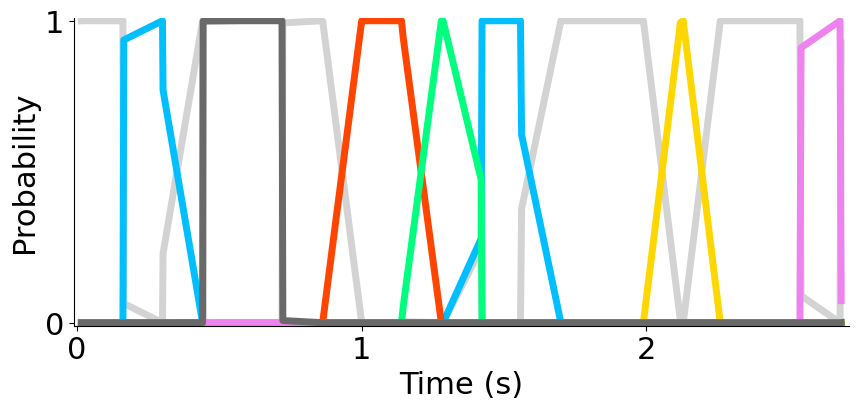

In [2]:
import scipy
word =  ['BLANK', 'I', 'T','H','N','K','>',]
colors = ['lightgray','deepskyblue', 'orangered', 'springgreen', 'gold', 'violet', 'dimgray',]
end_idx = 83
trial = 6
this_trial_clock = (np.array(redis_clock[trial])/1000)[:end_idx]

indices = []
for w in word:
    indices.append(CHAR_DEF.index(w))
to_plot = all_trial_logits[trial][:end_idx]
to_plot = np.array([i for i in to_plot if np.max(i) > 0])
this_trial_clock = np.array([clock for i,clock in zip(to_plot, this_trial_clock) if np.max(i) > 0])
to_plot = scipy.special.softmax(to_plot, axis = -1)
to_plot = to_plot[:, indices]

plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

fig = plt.gcf()
fig.set_size_inches(10, 4)
for char in range(len(indices)):
    x = this_trial_clock-0.55
    y = to_plot[:, char]

    plt.plot(x,y, label=word[char], linewidth=5, color=colors[char])
plt.ylabel('Probability', fontsize=22)
plt.xlabel('Time (s)', fontsize=22)

plt.yticks([0,1.0], fontsize=22)
plt.xticks([0,1,2], fontsize=22)
plt.savefig('T18-ITHINK-logits.pdf', bbox_inches='tight')